In [3]:
## Earthquake Data Analysis with Python

#- This project explores earthquake events using a dataset containing details such as magnitude, depth, location, and time.  
#- The goal is to identify trends, visualize global earthquake distribution, and better understand earthquake patterns.


In [4]:
## Objectives
#- Understand the global distribution of earthquakes.
#- Analyze earthquake magnitudes and depths.
#- Visualize hotspots where earthquakes occur most frequently.
#- Create clear charts and maps for insights.


In [5]:
## Data Overview
#The dataset contains earthquake events with the following key columns:
#- **time**: date and time of the earthquake
#- **latitude & longitude**: location
#- **magnitude**: strength of the earthquake
#- **depth**: depth at which the earthquake occurred

#We performed basic cleaning by handling missing values and selecting relevant columns.


In [6]:
import pandas as pd
import requests
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [7]:
url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"
data = requests.get(url).json()


In [8]:
df = json_normalize(data['features'])
df = df[['properties.mag', 'properties.place', 'properties.time', 'geometry.coordinates']]
df.rename(columns={
    'properties.mag': 'magnitude',
    'properties.place': 'location',
    'properties.time': 'time',
    'geometry.coordinates': 'coordinates'
}, inplace=True)
df[['longitude', 'latitude', 'depth']] = pd.DataFrame(df['coordinates'].tolist(), index=df.index)
df.drop(columns=['coordinates'], inplace=True)
df['time'] = pd.to_datetime(df['time'], unit='ms')

df.head()


,magnitude,location,time,longitude,latitude,depth
0,1.30,"10 km W of Forsan, Texas",2025-09-16 11:12:48.748,-101.477000,32.096000,4.0327
1,1.43,"3 km NW of The Geysers, CA",2025-09-16 11:08:55.760,-122.785667,38.794167,3.0400
2,1.02,"5 km NNW of The Geysers, CA",2025-09-16 10:58:53.940,-122.795998,38.814499,3.4200
3,0.70,"16 km NW of Midland, Texas",2025-09-16 10:24:01.967,-102.190000,32.110000,5.8350
4,2.50,"91 km ESE of Ugashik, Alaska",2025-09-16 10:15:16.028,-155.997700,57.184400,13.6000


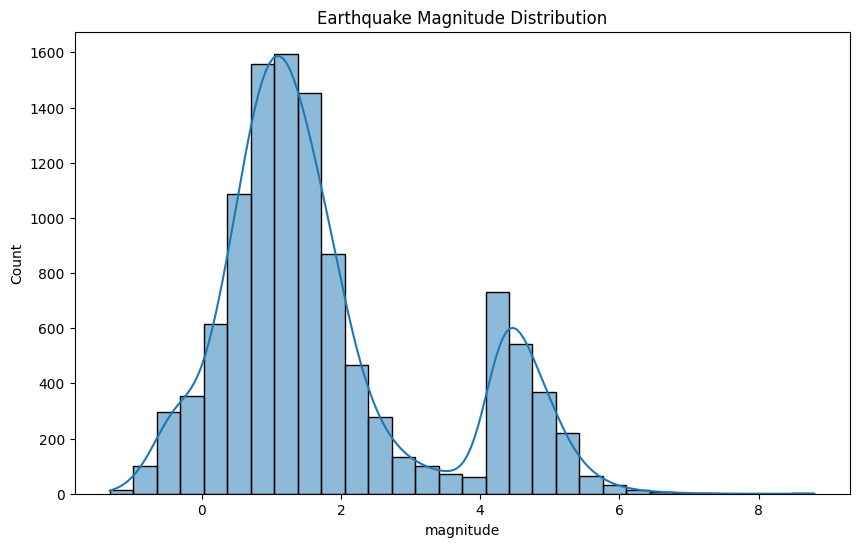

In [66]:
## Magnitude Distribution
##We first explore the distribution of earthquake magnitudes to understand how often small, moderate, and large earthquakes occur.

plt.figure(figsize=(10,6))
sns.histplot(df['magnitude'], bins=30, kde=True)
plt.title("Earthquake Magnitude Distribution")
plt.savefig("visuals/magnitude_distribution.png")
plt.show()


In [9]:
df.nlargest(10, 'magnitude')[['location', 'magnitude']]


,location,magnitude
8230,2025 Southern Drake Passage Earthquake,7.5
924,"111 km E of Petropavlovsk-Kamchatsky, Russia",7.4
2216,Vanuatu region,6.4
7197,east of the Kuril Islands,6.1
149,"145 km ESE of Petropavlovsk-Kamchatsky, Russia",6.0
3887,"87 km SW of Nikolski, Alaska",6.0
4999,"37 km WSW of Asadābād, Afghanistan",6.0
6664,"98 km E of Severo-Kuril’sk, Russia",6.0
7788,"81 km SW of Acajutla, El Salvador",6.0
3805,"91 km WSW of San Antonio de los Cobres, Argentina",5.9


In [10]:
map_eq = folium.Map(location=[0, 0], zoom_start=2)
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['magnitude'],
        color='red',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_eq)

map_eq.save("visuals/earthquake_map.html")


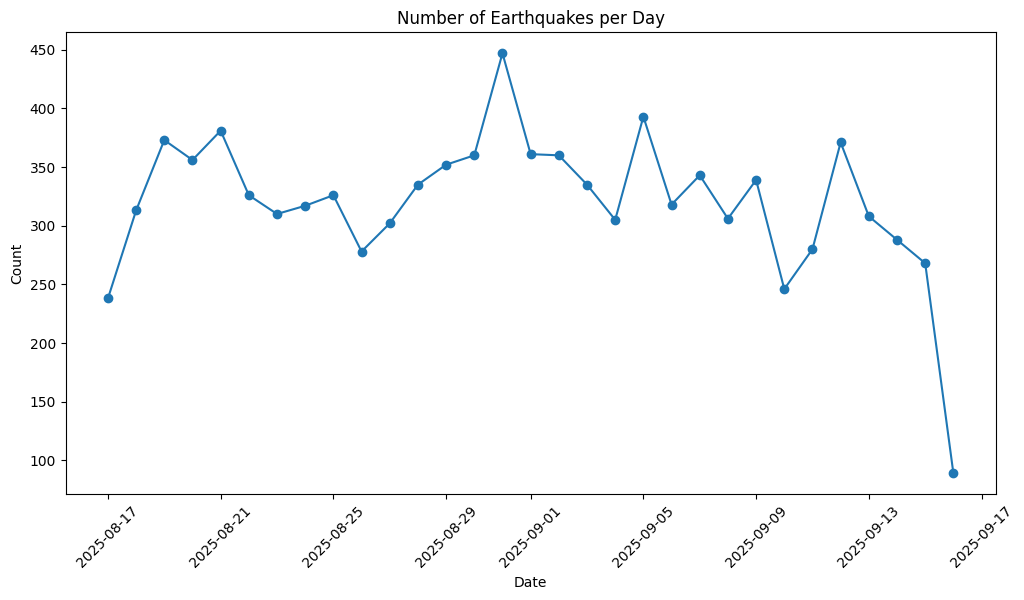

In [11]:
df['date'] = df['time'].dt.date
daily_counts = df.groupby('date').size()

plt.figure(figsize=(12,6))
daily_counts.plot(kind='line', marker='o')
plt.title("Number of Earthquakes per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("visuals/earthquakes_per_day.png")
plt.show()


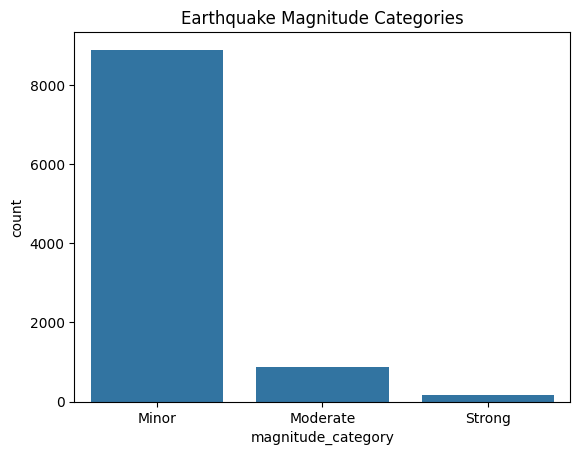

In [12]:
def magnitude_category(mag):
    if mag < 3:
        return "Minor"
    elif mag < 5:
        return "Moderate"
    else:
        return "Strong"

df['magnitude_category'] = df['magnitude'].apply(magnitude_category)

sns.countplot(x='magnitude_category', data=df, order=['Minor', 'Moderate', 'Strong'])
plt.title("Earthquake Magnitude Categories")
plt.savefig("visuals/magnitude_categories.png")
plt.show()


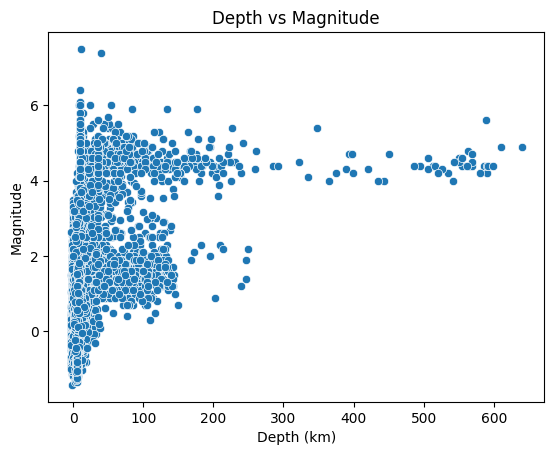

In [13]:
sns.scatterplot(x='depth', y='magnitude', data=df)
plt.title("Depth vs Magnitude")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.savefig("visuals/depth_vs_magnitude.png")
plt.show()


In [14]:
color_map = {"Minor":"green", "Moderate":"orange", "Strong":"red"}

map_eq = folium.Map(location=[0,0], zoom_start=2)
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4 + row['magnitude'],  # size proportional to magnitude
        color=color_map[row['magnitude_category']],
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['location']}, Mag: {row['magnitude']}"
    ).add_to(map_eq)

map_eq.save("visuals/earthquake_map.html")


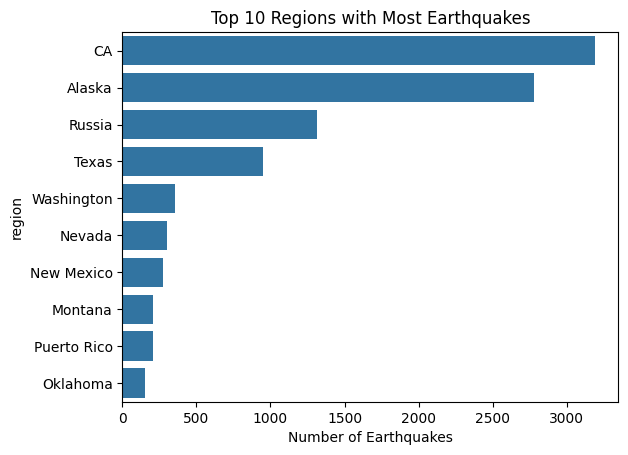

In [76]:
df['region'] = df['location'].apply(lambda x: x.split(',')[-1].strip())
top_regions = df['region'].value_counts().head(10)

sns.barplot(x=top_regions.values, y=top_regions.index)
plt.title("Top 10 Regions with Most Earthquakes")
plt.xlabel("Number of Earthquakes")
df['region'] = df['location'].apply(lambda x: x.split(',')[-1].strip())
top_regions = df['region'].value_counts().head(10)
plt.savefig("visuals/top_regions.png")
plt.show()
